In [1]:
# basis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import QuantileTransformer
# Model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import f1_score, roc_curve, auc, ConfusionMatrixDisplay


# Ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('banana_quality.csv')
df.head()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-1.924968,0.468078,3.077832,-1.472177,0.294799,2.435570,0.271290,Good
1,-2.409751,0.486870,0.346921,-2.495099,-0.892213,2.067549,0.307325,Good
2,-0.357607,1.483176,1.568452,-2.645145,-0.647267,3.090643,1.427322,Good
3,-0.868524,1.566201,1.889605,-1.273761,-1.006278,1.873001,0.477862,Good
4,0.651825,1.319199,-0.022459,-1.209709,-1.430692,1.078345,2.812442,Good


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         8000 non-null   float64
 1   Weight       8000 non-null   float64
 2   Sweetness    8000 non-null   float64
 3   Softness     8000 non-null   float64
 4   HarvestTime  8000 non-null   float64
 5   Ripeness     8000 non-null   float64
 6   Acidity      8000 non-null   float64
 7   Quality      8000 non-null   object 
dtypes: float64(7), object(1)
memory usage: 500.1+ KB


In [4]:
df.Quality.unique()

array(['Good', 'Bad'], dtype=object)

In [5]:
# Change Quality to categorical data type
quality_cat= CategoricalDtype(categories=['Good', 'Bad'])
df['Quality']= df['Quality'].astype(quality_cat)
df['Quality'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8000 entries, 0 to 7999
Series name: Quality
Non-Null Count  Dtype   
--------------  -----   
8000 non-null   category
dtypes: category(1)
memory usage: 8.1 KB


In [6]:
# Check for missing data
df.isnull().sum()

Size           0
Weight         0
Sweetness      0
Softness       0
HarvestTime    0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

In [7]:
# Check for duplicate data
df.duplicated().sum()

0

In [8]:
# Describe data
df.describe()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,-0.747802,-0.761019,-0.770224,-0.014441,-0.751288,0.781098,0.008725
std,2.136023,2.015934,1.948455,2.065216,1.996661,2.114289,2.293467
min,-7.998074,-8.283002,-6.434022,-6.959320,-7.570008,-7.423155,-8.226977
25%,-2.277651,-2.223574,-2.107329,-1.590458,-2.120659,-0.574226,-1.629450
50%,-0.897514,-0.868659,-1.020673,0.202644,-0.934192,0.964952,0.098735
75%,0.654216,0.775491,0.311048,1.547120,0.507326,2.261650,1.682063
max,7.970800,5.679692,7.539374,8.241555,6.293280,7.249034,7.411633


In [9]:
def single_plot_distribution(column_name, dataframe):
    # Get the value counts of the specified column
    value_counts = dataframe[column_name].value_counts()

    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]}) 

    # Donut pie chart
    ax1.pie(value_counts, autopct='%0.001f%%', startangle=90, pctdistance=0.85, labels=None)
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax1.add_artist(centre_circle)
    ax1.set_title(f'Distribution of {column_name}', fontsize=16)

    # Bar chart
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax2) 
    ax2.set_title(f'Count of {column_name}', fontsize=16)
    ax2.set_xlabel(column_name, fontsize=14)
    ax2.set_ylabel('Count', fontsize=14)

    # Show the plots
    plt.tight_layout()
    plt.show()

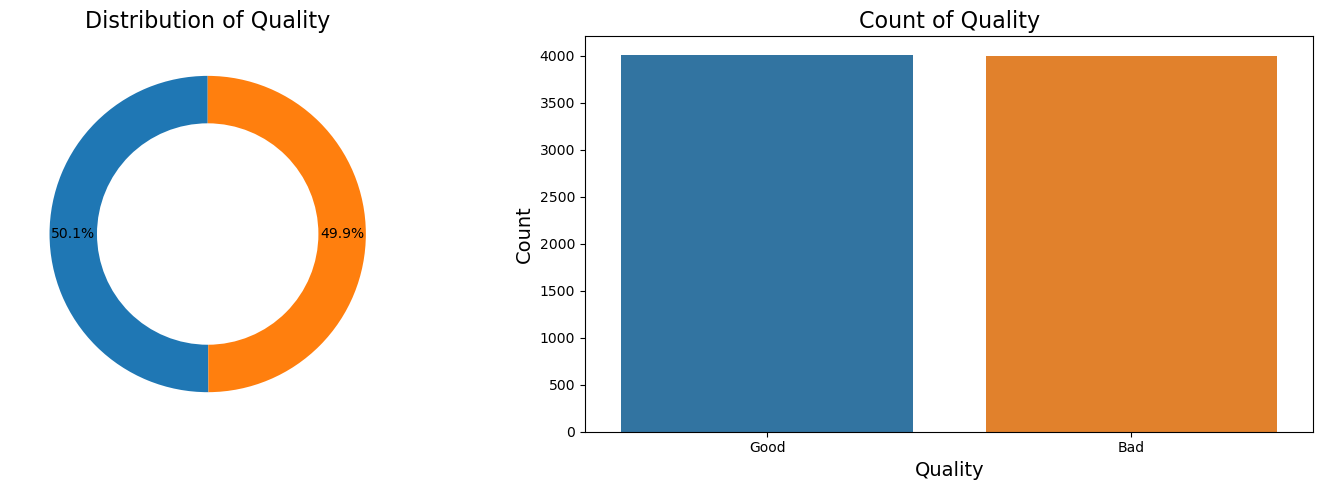

In [10]:
single_plot_distribution('Quality', df)

In [11]:
#sns.pairplot(df, hue='Quality')

<Axes: >

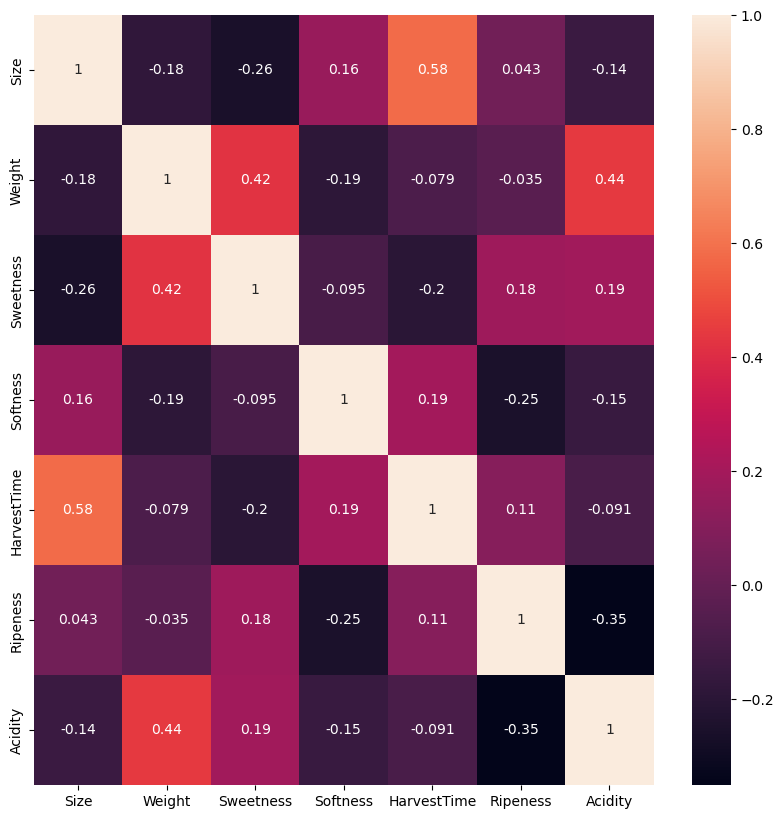

In [12]:
# Find correlation
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)

In [13]:
X = df.drop('Quality', axis=1)
y = df['Quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [14]:
# defining variables for future use
features = X_train.columns
train = pd.concat([X_train, y_train], axis=1)

In [15]:
from collections import Counter

def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        outlier_indices.extend(outlier_list_col)

    outlier_indices_counter = Counter(outlier_indices)        
    multiple_outliers = [ k for k, v in outlier_indices_counter.items() if v > n]
    
    return multiple_outliers, outlier_indices

In [16]:
outliers_to_drop, outliers = detect_outliers(X_train, 2, features)
print(f"{len(outliers)} samples contain outliers, {len(outliers_to_drop)} of them are outliers in more then two features.")

300 samples contain outliers, 0 of them are outliers in more then two features.


We don't have any outlier to drop

<Figure size 2000x1000 with 0 Axes>

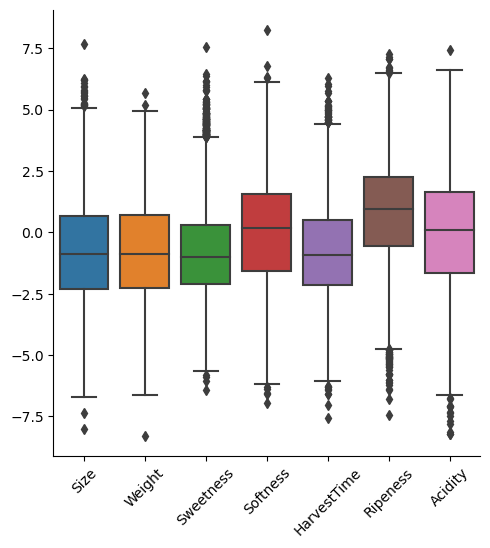

In [18]:
plt.figure(figsize=(20,10))
plt.tight_layout()
g = sns.catplot(data=X_train ,kind="box")
g.tick_params(axis='x', rotation=45)

In [19]:
features

Index(['Size', 'Weight', 'Sweetness', 'Softness', 'HarvestTime', 'Ripeness',
       'Acidity'],
      dtype='object')

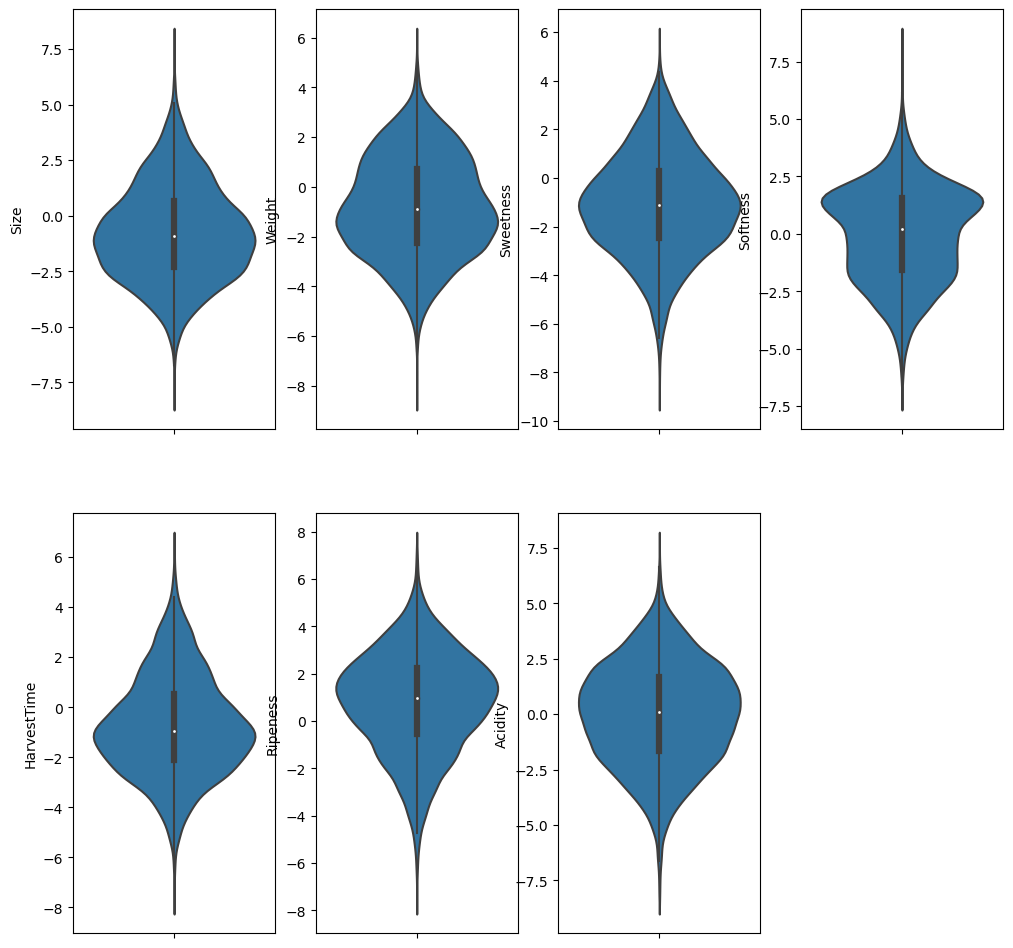

In [93]:
plt.figure(figsize = (12,12))
plt.tight_layout()
for i in range(len(features)):
    plt.subplot(2,len(features)//2 +1,i+1)
    sns.violinplot(data=X_train, y=X_train[features[i]])

The outliers is not drop

In [22]:
# check skewness for all numerical features
skewed_feats = X_train.apply(lambda x: x.skew()).sort_values(ascending=False)
print("\nSkew in numerical features (origin X_train): \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
skewness.head(11)


Skew in numerical features (origin X_train): 



,Skew
Sweetness,0.611
HarvestTime,0.294
Size,0.276
Weight,0.062
Acidity,-0.146
Softness,-0.206
Ripeness,-0.318


In [23]:
# Applying Yeo-Johnson Transformation
X_train['Sweetness'], _ = yeojohnson(X_train['Sweetness'])
print(f"Skewness after Yeo-Johnson Transformation: {X_train['Sweetness'].skew():.5f}")

Skewness after Yeo-Johnson Transformation: -0.01424


<Axes: >

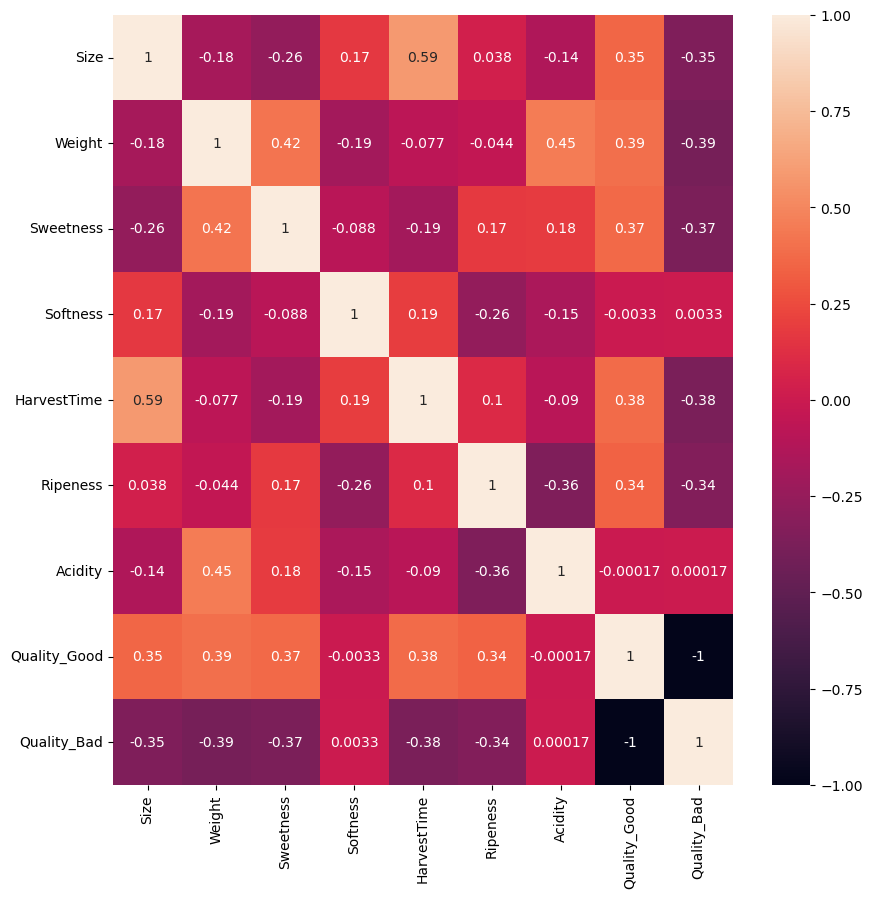

In [24]:
# Find correlation
train = pd.get_dummies(train, drop_first=False, columns=['Quality'])
corr = train.corr(numeric_only=True)

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)

## Visualizstion of data by label (t-SNE)

In [26]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_train)
tsne.shape

(6400, 2)

[Text(0.5, 0, 'X1'),
 Text(0, 0.5, 'X2'),
 Text(0.5, 1.0, 'Visualization of data in two dimentions by t-SNE')]

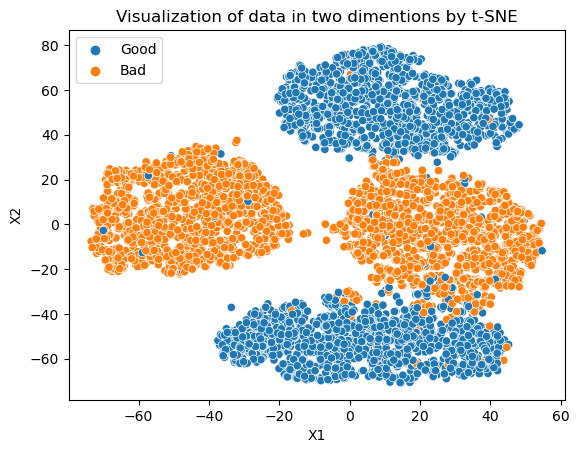

In [27]:
g = sns.scatterplot(data=tsne, x=tsne[:,0], y=tsne[:,1], hue=y_train.values)
g.set(xlabel='X1', ylabel='X2', title='Visualization of data in two dimentions by t-SNE')

## Unsupervised learning

In [29]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)

[Text(0.5, 0, 'X1'),
 Text(0, 0.5, 'X2'),
 Text(0.5, 1.0, 'Visualization of data in 2-D by t-SNE')]

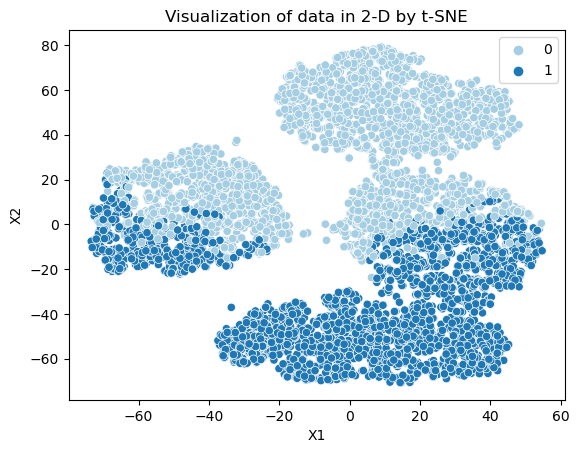

In [30]:
g = sns.scatterplot(data=tsne, x=tsne[:,0], y=tsne[:,1], hue=kmeans.labels_, palette="Paired")
g.set(xlabel='X1', ylabel='X2', title='Visualization of data in 2-D by t-SNE')

# Modeling

In [32]:
# Min-Max Normalization 

scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

In [33]:
# adjusting the format of the label to xgboost model

le = LabelEncoder()
y_train_gb = le.fit_transform(y_train)

In [ ]:
# choosing best estimators for Random Forest model: 
param_grid = {'max_depth': [2, 3, 4, 5, 6, 10, 100, 300], 'n_estimators':[100, 500, 1000]}  # what about n_estimators?? 
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid)
rf_model.fit(X_train, y_train)
print(f"Best estimators for Random Forest: {rf_model.best_estimator_}")

# choosing best estimators for AdaBoost model:
param_grid = {'n_estimators': [10, 20, 50, 100], 'learning_rate': [0.1, 0.2, 0.5, 0.7, 0.8, 1]}  
ada_model = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid)
ada_model.fit(X_train, y_train)
print(f"Best estimators for AdaBoost: {ada_model.best_estimator_}")

# choosing best estimators for svm model: 
param_grid = {'kernel': ['linear','poly','rbf'], 'C': [0.001, 0.01, 0.1, 1, 10],
                  'gamma': [1, 0.1]}  
svm_model = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid)
svm_model.fit(X_train_scaled, y_train)
print(f"Best estimators for SVM: {svm_model.best_estimator_}")

# choosing best estimators for KNN model:
param_grid = {'n_neighbors': list(range(3, 16, 2))}  
knn_model = GridSearchCV(KNeighborsClassifier(), param_grid)
knn_model.fit(X_train_scaled, y_train)
print(f"Best estimators for K-Nearest Neighbor: {knn_model.best_estimator_}")

# choosing best estimators for Gradient Boosting model:
param_grid = {'n_estimators': [10, 20, 50, 100, 300, 500], 'learning_rate': [0.1, 0.8, 1], 'max_depth' : [1, 2, 3, 5]}  
gb_model = GridSearchCV(XGBClassifier(random_state=42), param_grid)
gb_model.fit(X_train, y_train_gb)
print(f"Best estimators for Gradient Boosting: {gb_model.best_estimator_}")

In [36]:
rf = RandomForestClassifier(max_depth=2, random_state=42)
ada = AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42)
svm = SVC(kernel='poly', C=0.1, class_weight='balanced', gamma=1, probability=True, random_state=42)  
knn = KNeighborsClassifier(n_neighbors=7)
log = LogisticRegression(max_iter=400, random_state=42)
gb = XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=1, random_state=42)

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring='f1_micro',
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_micro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    return test_scores_mean, test_scores_std


rf_mean, rf_std = plot_learning_curve(rf,"Random Forest learning curves",X_train,y_train,cv=5)
ada_mean, ada_std = plot_learning_curve(ada,"AdaBoost learning curves",X_train,y_train,cv=5)
svm_mean, svm_std = plot_learning_curve(svm,"SVM learning curves",X_train_scaled,y_train,cv=5)
knn_mean, knn_std = plot_learning_curve(knn,"K-Nearest Neighbor learning curves",X_train_scaled,y_train,cv=5)
log_mean, log_std = plot_learning_curve(log,"Logistic regression learning curves",X_train_scaled,y_train,cv=5)
gb_mean, gb_std = plot_learning_curve(gb,"Gradient Boosting learning curves",X_train,y_train_gb,cv=5)

In [42]:
# printing accuracy and std of validation for each model
print(f"\nRandom Forest score: {rf_mean.mean():.2f} ({rf_std.mean():.2f})\n")
print(f"\nAdaBoost score: {ada_mean.mean():.2f} ({ada_std.mean():.2f})\n")
print(f"\nSVM score: {svm_mean.mean():.2f} ({svm_std.mean():.2f})\n")
print(f"\nK-Nearest Neighbor score: {knn_mean.mean():.2f} ({knn_std.mean():.2f})\n")
print(f"\nLogistic Regression score: {log_mean.mean():.2f} ({log_std.mean():.2f})\n")
print(f"\nGradient Boosting score: {gb_mean.mean():.2f} ({gb_std.mean():.2f})\n")


Random Forest score: 0.87 (0.01)


AdaBoost score: 0.89 (0.01)


SVM score: 0.91 (0.01)


K-Nearest Neighbor score: 0.98 (0.00)


Logistic Regression score: 0.87 (0.00)


Gradient Boosting score: 0.86 (0.01)



## Ensemble model

In [44]:
estimators = [('svm_stck', make_pipeline(scaler, SVC(kernel='linear', C=1, class_weight='balanced', gamma=1, probability=True, random_state=42))),
              ('knn_stck', make_pipeline(scaler, KNeighborsClassifier(n_neighbors=3))), 
              ('ada_stck', XGBClassifier(max_depth=1, n_estimators=50, random_state=42, learning_rate=0.1))]


X_train80, X_val, y_train80, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=42, stratify=y_train)

In [46]:
final_estimator = LogisticRegression(max_iter=400) 

stck = StackingClassifier(estimators=estimators, final_estimator=final_estimator, stack_method='predict')

accuracy = stck.fit(X_train80, y_train80).score(X_val, y_val)
print(f"\nStacking model accuracy: {accuracy:.2f}\n")

stck_pred = stck.predict(X_val)
f1 = f1_score(y_val, stck_pred, average='macro')
print(f"\nStacking model f1 score: {f1:.2f}\n")


Stacking model accuracy: 0.98


Stacking model f1 score: 0.98



The result is same as KNN

In [47]:
vote = VotingClassifier(estimators=estimators, voting='soft')
accuracy = vote.fit(X_train80, y_train80).score(X_val, y_val)
print(f"\nMajority vote accuracy: {accuracy:.2f}\n")

vote_pred = vote.predict(X_val)
f1 = f1_score(y_val, vote_pred, average='macro')
print(f"\nMajority vote model f1 score: {f1:.2f}\n")


Majority vote accuracy: 0.96


Majority vote model f1 score: 0.96



The result is lower than KNN

# Results

## Preparing test data

In [58]:
X_test['Sweetness'], _ = yeojohnson(X_test['Sweetness'])
print(f"Skewness after Yeo-Johnson Transformation: {X_train['Sweetness'].skew():.5f}")

Skewness after Yeo-Johnson Transformation: -0.01424


In [61]:
# Min-Max Normalization

X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [64]:
# adjusting the format of the label to xgboost model

y_test_gb = le.fit_transform(y_test)

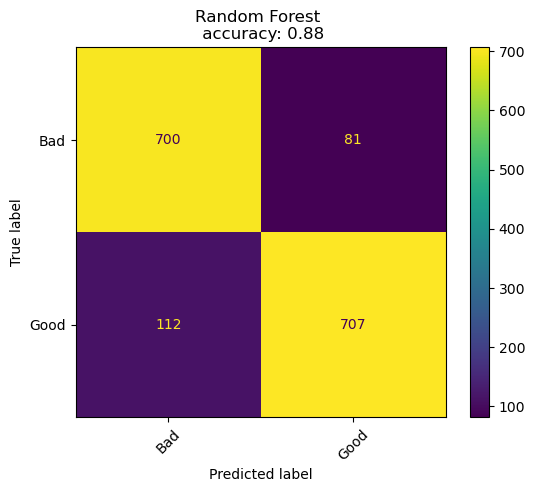

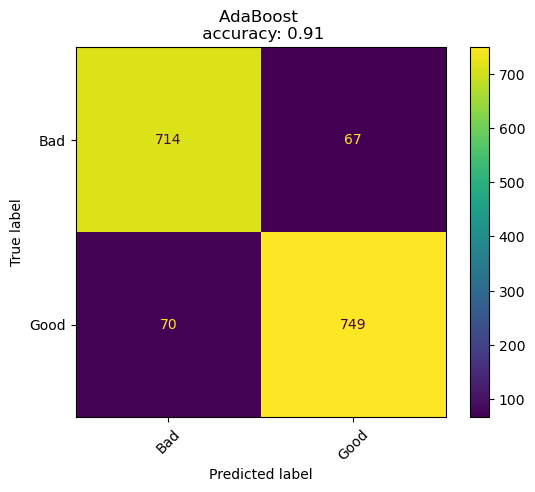

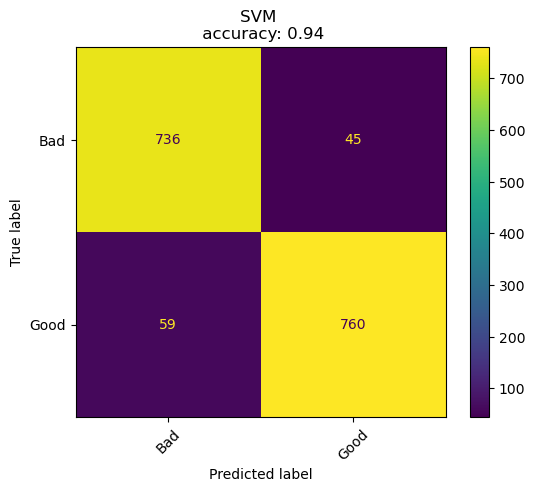

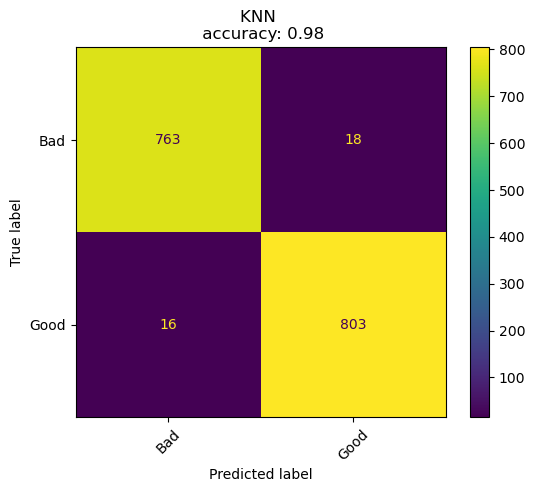

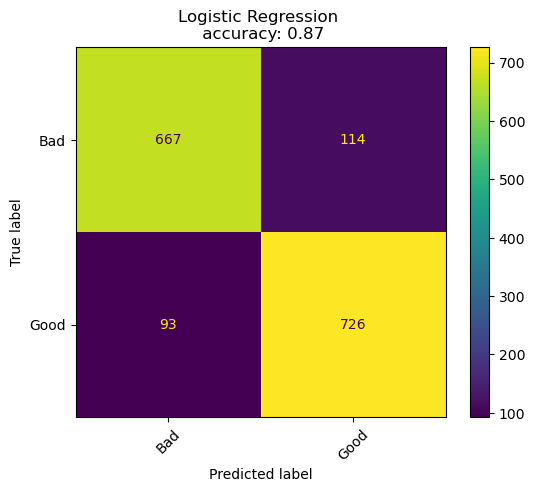

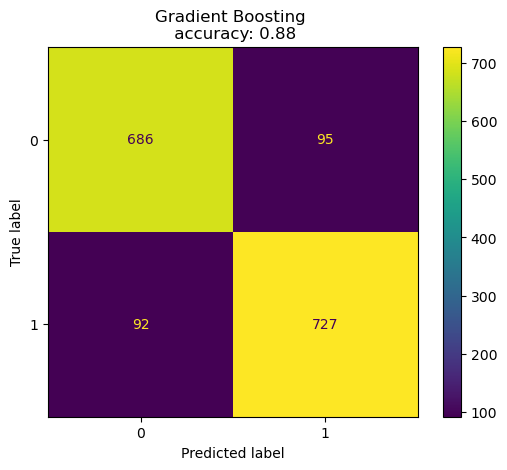

In [67]:
models = [rf, ada, svm, knn, log, gb] 
names = ["Random Forest", "AdaBoost", "SVM", "KNN", "Logistic Regression", "Gradient Boosting"] 


for model, name in zip(models, names):
    
    if model in [svm, knn, log]:
        y_pred = model.fit(X_train_scaled, y_train).predict(X_test_scaled)
        fig = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=45)
        fig.ax_.set_title(f"{name} \n accuracy: {model.score(X_test_scaled, y_test):.2f}")

    elif model == gb:
        y_pred = model.fit(X_train, y_train_gb).predict(X_test)
        fig = ConfusionMatrixDisplay.from_predictions(y_test_gb, y_pred)
        fig.ax_.set_title(f"{name} \n accuracy: {model.score(X_test, y_test_gb):.2f}")
        
    else:
        y_pred = model.fit(X_train, y_train).predict(X_test)
        fig = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation=45)
        fig.ax_.set_title(f"{name} \n accuracy: {model.score(X_test, y_test):.2f}")
        
plt.show()


In [70]:
for model, name in zip(models, names):
    if model in [svm, knn, log]:
        score = model.score(X_test_scaled, y_test)
        print(f"\n{name} score: {score:.2f}\n")
    elif model == gb:
        score = model.score(X_test, y_test_gb)
        print(f"\n{name} score: {score:.2f}\n")
    else:
        score = model.score(X_test, y_test)
        print(f"\n{name} score: {score:.2f}\n")


Random Forest score: 0.88


AdaBoost score: 0.91


SVM score: 0.94


KNN score: 0.98


Logistic Regression score: 0.87


Gradient Boosting score: 0.88

